# Image classification framework

#### João Fernando Mari

* [joaofmari.github.io](joaofmari.github.io)
* [github.com/joaofmari](github.com/joaofmari)
---

## Importing the libraries
---

In [1]:
import sys
import os
import argparse
import random
import time
import pickle
import datetime

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import sklearn
from sklearn import metrics, model_selection, preprocessing
### import pandas as pd

import torch
from torch import nn, optim

import torchvision
from torchvision import transforms, models, datasets, utils

# Local imports
from early_stopping import EarlyStopping
from models import create_model
from data_aug_3 import get_da

In [2]:
# Para calcular o tempo total do experimento.
time_exp_start = time.time() 

## Configuring GPU...
---

In [3]:
print('Configuring GPU...')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\nDevice: {DEVICE}')

Configuring GPU...

Device: cuda


## Argument parsing
---

In [4]:
parser = argparse.ArgumentParser()
# Main
parser.add_argument('--ds', help='Dataset name.', type=str, default='Weeds')
parser.add_argument('--ds_split', help='How ds is split: ["train-val-test", "train-test", "no-split"].', type=str, default='no-split')
parser.add_argument('--arch', help='CNN architecture.', type=str, default='alexnet', )
parser.add_argument('--optim', help="Hyperparameter optmization: ['none', 'grid', 'random'].", type=str, default='none', )
# Aux
parser.add_argument('--sm', help='Save the model?', default=True, action='store_true')
parser.add_argument('--seed', help='Seed for random number generator.', type=int, default=42)
parser.add_argument('--num_workers', help='Number of available cores.', type=int, default=2)
parser.add_argument('--ec', help='Experiment counter. Used for hp optimization.', type=int, default=0)
parser.add_argument('--debug', help="Is running in debug mode?", required=False, default=False, action='store_true')
# Otimizador
parser.add_argument('--optimizer', help="Optimizer. ['SGD', 'Adam'].", type=str, default='Adam')
parser.add_argument('--scheduler', help="Scheduler. ['steplr', 'cossine', 'plateau'].", type=str, default='plateau')
# Hyperparameters 
parser.add_argument('--bs', help='Barch size.', type=int, default=64)
parser.add_argument('--lr', help='Learning rate.', type=float, default=0.0001)
parser.add_argument('--mm', help='Momentum.', type=float, default=0.9)
parser.add_argument('--ss', help='Step size.', type=int, default=5)
### parser.add_argument('--wd', help='Weight decay.', type=float, default=0.1)
parser.add_argument('--ep', help='Number of epochs', type=int, default=200) 
# Fine-tunning
parser.add_argument('--ft', help='Treinamento com fine-tuning.', default=True, action='store_true')
# Data augmentation strategy. Ignorado se otimização de hiperparametros
parser.add_argument('--datrain', help='Data augmentation stretegy for training. 0 = no data augmentation.',  type=int, default=0)
parser.add_argument('--daval', help='Data augmentation stretegy for validating. 0 = no data augmentation.',  type=int, default=0)
parser.add_argument('--datest', help='Data augmentation stretegy for testing. 0 = no data augmentation.',  type=int, default=0)
# Usa BCELoss em problemas com duas classes. Se False, usa CrossEntropyLoss para qualquer número de classes
parser.add_argument('--bce', help='Usa Binary Cross Entropy em problemas com duas classes.', default=True, action='store_true')
# Explainable AI
parser.add_argument('--xai', help='Perform eXplainable AI analysis.', default=False, action='store_true')
# Early stopping
parser.add_argument('--es', help='Use early stopping.', default=True, action='store_true')
parser.add_argument('--patience', help='Patience for early stopping.', type=int, default=21) # Use 21, if plateau
parser.add_argument('--delta', help='Delta for early stopping', type=float, default=0.0001)

# ***** IMPORTANTE!!! *****
# Comentar esta linha após gerar o arquivo .py!
# *************************
sys.argv = ['-f']

# Processa os argumentos informados na linha de comando
args = parser.parse_args()

# ***** IMPORTANTE!!! *****
# Set DEBUG mode:
# *************************
args.debug = True

if args.debug:
    args.ds = 'Weeds'
    args.ds_split = 'no-split'
    args.arch = 'resnet50'
    args.optimizer = 'Adam'
    args.bs = 16 #64 #8
    args.ec = 0
    args.ep = 2
    args.datrain = 2
    args.daval = 1
    args.datest = 1

# Performing Training...
TRAIN = True

# Split the TRAINING set in TRAINING and VALIDATION SET.
# If False, the test set is used for validation.
# (Não se aplica a 'train-val-test'). Na dúvida, manter True.
SPLIT_VAL = True

In [5]:
if str(DEVICE) != 'cuda':
    print('CUDA not available. Finishing the program...')
    print('\nDone!\n\n')
    sys.exit()

if args.optim != 'none':
    # If hp optimization, do not save model.
    args.sm = False
    # If you want to fix a da strategy when hp optim, unncoment...
    ### args.da = 0
    # if hp optimization, always ignore XAI.
    args.xai = False

### Save arguments

In [6]:
args_str = ''
for arg in vars(args):
    args_str += f'\n{arg}: {getattr(args, arg)}'
    print(f'{arg}: {getattr(args, arg)}')

ds: Weeds
ds_split: no-split
arch: resnet50
optim: none
sm: True
seed: 42
num_workers: 2
ec: 0
debug: True
optimizer: Adam
scheduler: plateau
bs: 16
lr: 0.0001
mm: 0.9
ss: 5
ep: 2
ft: True
datrain: 2
daval: 1
datest: 1
bce: True
xai: False
es: True
patience: 21
delta: 0.0001


In [7]:
def get_versions():
    str = ''
    str += f'\nNumPy: {np.__version__}'
    str += f'\nMatplotlib: {matplotlib.__version__}'
    ### str += f'\nPandas: {pd.__version__}'
    str += f'\nPIL: {PIL.__version__}'
    str += f'\nScikit-learn: {sklearn.__version__}'
    str += f'\nPyTorch: {torch.__version__}'
    str += f'\nTorchvision: {torchvision.__version__}'

    return str

## Customized Dataset
---

In [8]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, path_list, label_list, transforms=None):
        self.path_list = path_list
        self.label_list = label_list
        self.transforms = transforms

    def __len__(self):
        # Número de imagens.
        return len(self.path_list)

    def __getitem__(self, idx):
        # Caminho para a imagem.
        path = self.path_list[idx]
        # Carrega a imagem.
        image = Image.open(self.path_list[idx]) 

        if np.array(image).ndim != 3:
            # Converte imagens em níveis de cinza (com apenas 1 canal) para RGB
            image = image.convert(mode='RGB')
        elif np.array(image).shape[2] > 3:
            # Trata imagens com canal de transparência (com 4 canais)
            image = image.convert(mode='RGB')

        # Rótulo da imagem (classe)
        label = self.label_list[idx]

        # Aplica transformações na imagem (data augmentation)
        if self.transforms:
            image = self.transforms(image)

        # Retorna a imagem, rótulo da imagem (classe), e o caminho para o arquivo da imagem.
        return (image, label, path)   

## Configurating datasets
---

In [9]:
# # Caminho para a pasta que contém TODOS os seus datasets
# # ***** IMPORTANTE!!! *****
# # Alterar de acordo com a sua máquina.
# # *************************
# DS_PATH_MAIN = '/home/bianca/Área de Trabalho/Weeds/'

# # A pasta do dataset deve possuir o mesmo nome do dataset.
# # Ajustar o caminho, dentro da pasta do dataset, para a pasta que contém as imagens (no-split), ou que contém as pastas 'train', 'test' e, se existir, 'val'.
# if args.ds != 'dataset': # no-split
#     DS_PATH = os.path.join(DS_PATH_MAIN, args.ds, 'dataset_')
# # elif ...
#     # Incluir configurações de outros datasets.

# print(f'Dataset: {args.ds}')
# print(f'Dataset Path: {DS_PATH}')

# *************************
# DS_PATH_MAIN = '/home/bianca/Área de Trabalho/Weeds/'

# if args.ds != 'dataset':
#     DS_PATH = os.path.join(DS_PATH_MAIN, args.ds, 'dataset_')
# else:
#     DS_PATH = DS_PATH_MAIN
    
# print(f'Dataset: {args.ds}')
# print(f'Dataset Path: {DS_PATH}')

args_ds = 'dataset_' 

DS_PATH_MAIN = '/home/bianca/Datasets/' # DS_PATH_MAIN = '/home/bianca/Área\de/Trabalho/Weeds/'

if args.ds == 'Weeds':
    DS_PATH = os.path.join(DS_PATH_MAIN, args.ds, 'dataset_')
# elif arg.ds == '___':
#     pass

print(f'Dataset: {args_ds}')
print(f'Dataset Path: {DS_PATH}')


Dataset: dataset_
Dataset Path: /home/bianca/Datasets/Weeds/dataset_


## Gravação dos experimentos
---

In [10]:
# Pasta principal para armazenar TODOS os experimentos
if args.optim != 'none':
    # If hyperparameter optimization
    EXP_PATH_MAIN = f'exp_hp_{args.ds}'
elif args.debug == True:
    # If debug mode
    EXP_PATH_MAIN = f'exp_debug_{args.ds}'
else:
    # Execução normal
    EXP_PATH_MAIN = f'exp_{args.ds}'

# Check if EXP_PATH_MAIN exists. If not, create it.
if not os.path.isdir(EXP_PATH_MAIN): os.mkdir(EXP_PATH_MAIN)

# Momentum. Only if optmizer is SGD
mm_str = f'-mm_{args.mm}' if args.optimizer == 'SGD' else ''
# Step size. Only if scheduler is steplr
ss_str = f'-ss_{args.ss}' if args.scheduler == 'steplr' else ''

# String contendo os valores dos hiperparametros deste experimento.
hp_str = f'-bs_{args.bs}-lr_{args.lr}-op_{args.optimizer}{mm_str}-sh_{args.scheduler}{ss_str}-epochs_{args.ep}'

# Ajusta para o nome da pasta
hp_optim = '' if args.optim == 'none' else f'-{args.optim}'

# Pasta que ira armazenar os resultados deste treinamento
EXP_PATH = os.path.join(EXP_PATH_MAIN, f'({args.ds})-{args.arch}{hp_optim}-datrain_{args.datrain}-daval_{args.daval}{hp_str}')
print(f'Exp path: {EXP_PATH}')

# Check if EXP_PATH exists. If not, create it.
if not os.path.exists(EXP_PATH): os.mkdir(EXP_PATH)

else:
    # If the folder already exists, it is possible the experiment should (or shouldn't) be complete.
    # Nós verificamos, observando se o arquivo 'done.txt' está na pasta.
    # O arquivo 'done.txt' só é criado quando o experimento terminou por completo.
    if os.path.exists(os.path.join(EXP_PATH, 'done.txt')):
        # The folder exists and the experiment is done.
        print('Model already trained! Performing prediction...')

        TRAIN = False

Exp path: exp_debug_Weeds/(Weeds)-resnet50-datrain_2-daval_1-bs_16-lr_0.0001-op_Adam-sh_plateau-epochs_2


### Prediction path

In [11]:
if TRAIN:
    with open(os.path.join(EXP_PATH, 'general_report.txt'), 'w') as model_file:
        model_file.write('\nArguments:')
        ### model_file.write(str(args.__str__()))
        model_file.write(args_str)
        model_file.write('\n\nPackage versions:')
        model_file.write(str(get_versions()))

# Reprodutibility configurations
---

In [12]:
random.seed(args.seed)
np.random.seed(args.seed)

torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

os.environ["PYTHONHASHSEED"] = str(args.seed)

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
if args.arch != 'alexnet':
    torch.use_deterministic_algorithms(True)

## Preparing the dataset
---

### Setting data transformations (data augmentation)

In [13]:
# Média e desvio padrão do ImageNet.
DS_MEAN = [0.485, 0.456, 0.406]
DS_STD =  [0.229, 0.224, 0.225]

In [14]:
### data_transforms_train, data_transforms_val, data_transform_test = get_da(args.da, DS_MEAN, DS_STD)
data_transforms_train = get_da(args.datrain, DS_MEAN, DS_STD)
data_transforms_val = get_da(args.daval, DS_MEAN, DS_STD)
data_transform_test = get_da(args.datest, DS_MEAN, DS_STD)

## Datasets and dataloaders
---

### Dataset split

In [15]:
if args.ds_split == 'train-val-test':
    pass

In [16]:
if args.ds_split == 'train-test':
    pass

In [17]:
if args.ds_split == 'no-split':
    class_names = os.listdir(DS_PATH)
    class_names.sort()
    num_classes = len(class_names)

    # Conjunto de treino original
    X_ = []
    y_ = []

    for class_ in class_names:
        #lista ordenada dos arquivos (imagens) em cada pasta
        path_list_ = os.listdir(os.path.join(DS_PATH, class_))
        path_list_.sort()

        for path_image in path_list_:
            file_path = os.path.join(DS_PATH, class_, path_image)
            X_.append(file_path)
            y_.append(class_)


    # Divisão do conjunto de treino para validação
    le = preprocessing.LabelEncoder()
    le.fit(class_names)
    y_idx = le.transform(y_)

    # Separa o conjunto de testes
    TEST_SIZE  = 0.2
    X_train_, X_test, y_train_idx_, y_test_idx = model_selection.train_test_split(X_, 
                                                                                  y_idx, 
                                                                                  test_size=TEST_SIZE, 
                                                                                  stratify=y_idx, 
                                                                                  random_state=42)


    if SPLIT_VAL == True:
        VAL_SIZE_ = 0.2
        VAL_SIZE = VAL_SIZE_ / (1 - VAL_SIZE_)

        ### X_train, X_val, y_train, y_val_idx = model_selection.train_test_split(X_train_, y_train_idx, test_size=VAL_SIZE, stratify=y_train_idx, random_state=42)
        X_train, X_val, y_train_idx, y_val_idx = model_selection.train_test_split(X_train_, 
                                                                                  y_train_idx_, 
                                                                                  test_size=VAL_SIZE, 
                                                                                  stratify=y_train_idx_, 
                                                                                  random_state=42)

    else:
        X_train = X_train_
        X_val = X_test
        y_train_idx = y_train_idx_
        y_val_idx = y_test_idx

In [ ]:
print('DEBUG - Class names:')
class_names_ = le.classes_
print(class_names_)
print(class_names)

class_names = class_names_

### Dataset building

In [18]:
train_dataset = CustomDataset(X_train, y_train_idx, transforms=data_transforms_train)
val_dataset = CustomDataset(X_val, y_val_idx, transforms=data_transforms_val)
test_dataset = CustomDataset(X_test, y_test_idx, transforms=data_transform_test)

# Tamanho dos conjuntos de treino e de validação (número de imagens).
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

10505
3502
3502


### Dataloaders building

In [19]:
# Construindo os Dataloaders
dataloader_train = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=args.bs, 
                                               num_workers=args.num_workers,
                                               shuffle=True,
                                              )

dataloader_val = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=args.bs, 
                                             num_workers=args.num_workers,
                                             shuffle=True,
                                            )
# O mesmo que dataloader_val, porém com shuffle=False.
dataloader_val2 = torch.utils.data.DataLoader(val_dataset,
                                              batch_size=args.bs, 
                                              num_workers=args.num_workers,
                                              shuffle=False,
                                             )


dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=args.bs, 
                                              num_workers=args.num_workers,
                                              shuffle=False,
                                             )

## Visualizando um lote de imagens
---

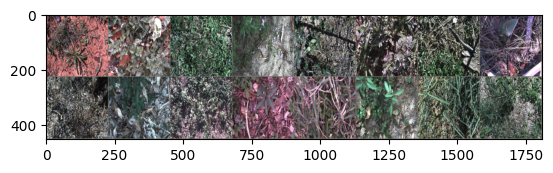

In [20]:
def save_batch(images_batch):
    """ Save one batch of images in a grid.

    References
    ----------
    * https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3
    * https://pub.towardsai.net/image-classification-using-deep-learning-pytorch-a-case-study-with-flower-image-data-80a18554df63
    """

    # Unnormalize all channels (ImageNet weights)
    for t, m, s in zip(images_batch, DS_MEAN, DS_STD):
        t.mul_(s).add_(m)
        # The normalize code -> t.sub_(m).div_(s)

    images_batch_np = images_batch.numpy()
    fig_obj = plt.imshow(np.transpose(images_batch_np, (1, 2, 0)))
    
    # Grava a figura em disco
    plt.savefig(os.path.join(EXP_PATH, 'sample_batch.png')) 
    plt.savefig(os.path.join(EXP_PATH, 'sample_batch.pdf')) 


if TRAIN:
    items = iter(dataloader_train)
    image, label, *_ = next(items)

    save_batch(utils.make_grid(image))

## Inicializando o modelo
---

In [21]:
if TRAIN:
    print('\n>> Inicializando o modelo...')

    model, input_size, _ = create_model(args.arch, args.ft, num_classes, args.bce)

    # Envia o modelo para a GPU
    model = model.to(DEVICE) 
        
    # Imprime o modelo
    print(str(model))

    # Grava a modelo da rede em um arquivo .txt
    with open(os.path.join(EXP_PATH, 'model.txt'), 'w') as model_file:
        model_file.write(str(model))


>> Inicializando o modelo...

Model: ResNet (resnet50)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
    

## Loss function and optimizer
---

In [22]:
if TRAIN:
    # Função de perda
    if num_classes > 2 or args.bce == False:
        # Classificação com mais de duas classes.
        criterion = nn.CrossEntropyLoss()
        
    else:
        criterion = nn.BCEWithLogitsLoss()
        print('criterion = nn.BCEWithLogitsLoss()')

    # Otimizador
    if args.optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.mm)

    elif args.optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr)

    print(criterion)
    print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


### Scheduler

In [23]:
if TRAIN:
    if args.scheduler == 'plateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, )
        print(scheduler)

    elif args.scheduler == 'cossine':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                         T_max=len(dataloader_train), 
                                                         eta_min=0,
                                                         last_epoch=-1)
        print(scheduler)

    elif args.scheduler ==  'steplr':
        # Step size of the learning rate
        if args.ss != 0:
            # https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#StepLR
            scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                                  step_size=args.ss)
            
            print(scheduler)

    else:
        print('No LR scheduler...')

## Training the model
---

In [24]:
if TRAIN:
    print('\n>> Training the model...')

    # Tempo total do treinamento (treinamento e validação)
    time_total_start = time.time()

    # Lista das perdas (loss) e acurácias (accuracy) de trino para cada época.
    train_loss_list = []
    train_acc_list = []

    # Lista das perdas (loss) e acurácias (accuracy) de validação para cada época.
    val_loss_list = []
    val_acc_list = []

    lr_list = []

    if args.es:
        early_stopping = EarlyStopping(patience=args.patience, delta=args.delta)

    for epoch in range(args.ep):
        # =====================================================================
        # TRAINING
        # =====================================================================
        # Inicia contagem de tempo desta época
        time_epoch_start = time.time()

        # Perdas (loss) nesta época
        train_loss_epoch = 0.
        # Número de amostras classificadas corretamente nesta época
        train_num_hits_epoch = 0  

        # Habilita o modelo para o modo de treino 
        model.train() 

        # Iterate along the batches of the TRAINING SET
        # ---------------------------------------------
        for i, (inputs, labels, *_) in enumerate(dataloader_train):
            # Envia os dados para a GPU
            inputs = inputs.to(DEVICE) 
            labels = labels.to(DEVICE) 

            # Zera os parametros do gradiente
            optimizer.zero_grad() 

            # FORWARD
            # ------>
            # Habilita o cálculo do gradiente
            torch.set_grad_enabled(True) 

            # Saída do modelo
            outputs = model(inputs) 

            if num_classes == 2 and args.bce:
                # Calculate probabilities
                # https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/27
                outputs_prob = torch.sigmoid(outputs) 
                preds = (outputs_prob > 0.5).float().squeeze()

                # Calcula a perda (loss)
                loss = criterion(outputs.squeeze(), labels.float())

            else:
                # 'outputs' estão em porcentagens. Tomar os maximos como a respostas.
                # Ex: batch=3 com 2 classes, entao preds = [1, 0, 1]
                preds = torch.argmax(outputs, dim=1).float() 

                # Calcula a perda (loss)
                loss = criterion(outputs, labels)

            # BACKWARD
            # <-------
            loss.backward() 

            # Atualiza o gradiente 
            optimizer.step()

            # Atualiza o loss da época
            train_loss_epoch += float(loss.item()) * inputs.size(0) 

            # Atualiza o número de amostras classificadas corretamente nessa época.
            train_num_hits_epoch += torch.sum(preds == labels.data) 

        train_loss_epoch /= len(train_dataset)
        train_acc_epoch = float(train_num_hits_epoch.double() / len(train_dataset))

        # Store loss and accuracy in lists
        train_loss_list.append(train_loss_epoch)
        train_acc_list.append(train_acc_epoch)

        # =====================================================================
        # VALIDATION
        # =====================================================================
        model.eval() 

        # Perdas (loss) nesta época
        val_loss_epoch = 0. 
        # Número de amostras classificadas corretamente nesta época
        val_num_hits_epoch = 0 
        
        # Iterate along the batches of the VALIDATION SET
        # -----------------------------------------------
        for i, (inputs, labels, *_) in enumerate(dataloader_val):
            # Envia o modelo para a GPU
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Zero o gradiente antes do calculo do loss
            optimizer.zero_grad() 

            # Desabilita o gradiente, pois os parametros nao mudam na etapa de validacao
            torch.set_grad_enabled(False) 

            # Gera a saida a partir da entrada
            outputs = model(inputs) 

            if num_classes == 2 and args.bce:
                # Calculate probabilities
                # https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/27
                outputs_prob = torch.sigmoid(outputs) 
                preds = ((outputs_prob > 0.5).float()).squeeze()

                # Calcula a perda (loss)
                loss = criterion(outputs.squeeze(), labels.float())

            else:
                # Retorna a maior predicao.
                preds = torch.argmax(outputs, dim=1).float()

                # Calcula a perda (loss)
                loss = criterion(outputs, labels) 

            # Loss acumulado na época
            val_loss_epoch += float(loss.item()) * inputs.size(0)

            # Acertos acumulados na época
            val_num_hits_epoch += torch.sum(preds == labels.data)

        # Ajusta o learning rate
        if args.scheduler == 'steplr' and args.ss != 0:
            scheduler.step() 
        
        elif args.scheduler == 'cossine' and epoch >= 10:
            scheduler.step()

        elif args.scheduler == 'plateau':
            scheduler.step(val_loss_epoch)

        # Obtém o lr neste época.
        lr_epoch = optimizer.param_groups[0]['lr']
        lr_list.append(lr_epoch)
            
        # Calculo a perda e acuracia de todo o conjunto de validacao
        val_loss_epoch /= len(val_dataset)
        val_acc_epoch = float(val_num_hits_epoch.double() / len(val_dataset))

        # Inserindo a perda e acuracia para os arrays 
        val_loss_list.append(val_loss_epoch)
        val_acc_list.append(val_acc_epoch)

        if args.es:
            early_stopping(val_loss_epoch, model, epoch)
            
            if early_stopping.early_stop:
                print(f'Early stopping in epoch {early_stopping.best_epoch}!')
                break

        # Calculo de tempo total da época
        time_epoch = time.time() - time_epoch_start
        
        # PRINTING
        # --------
        print(f'Epoch {epoch}/{args.ep - 1} - TRAIN Loss: {train_loss_epoch:.4f} VAL. Loss: {val_loss_epoch:.4f} - TRAIN Acc: {train_acc_epoch:.4f} VAL. Acc: {val_acc_epoch:.4f} ({time_epoch:.4f} seconds)')

    # Calcula do tempo total do treinamento (treinamento e validação)
    time_total_train = time.time() - time_total_start

    # PRINTING
    print(f'Treinamento finalizado. ({int(time_total_train // 60)}m {int(time_total_train % 60)}s)')


>> Training the model...
Epoch 0/1 - TRAIN Loss: 0.6450 VAL. Loss: 0.4810 - TRAIN Acc: 0.7810 VAL. Acc: 0.8315 (883.2805 seconds)
Epoch 1/1 - TRAIN Loss: 0.3487 VAL. Loss: 0.4364 - TRAIN Acc: 0.8836 VAL. Acc: 0.8649 (883.7590 seconds)
Treinamento finalizado. (29m 27s)


In [25]:
if TRAIN:
    if args.es:
        # load the last checkpoint with the best model
        model.load_state_dict(torch.load('checkpoint.pt'))

        file_obj = open(os.path.join(EXP_PATH, 'es.obj'), 'wb')
        pickle.dump(early_stopping, file_obj)
        file_obj.close()

    # Saving the model
    if args.sm:
        model_file = os.path.join(EXP_PATH, 'model.pth')
        torch.save(model, model_file)

else:
    model = torch.load(os.path.join(EXP_PATH, 'model.pth'))
    model.eval()

    file_obj = open(os.path.join(EXP_PATH, 'es.obj'), 'rb')
    early_stopping = pickle.load(file_obj)
    file_obj.close()

    train_acc_list = [0]
    val_acc_list = [0]
    time_total_train = 0

## Analisando o treinamento
---

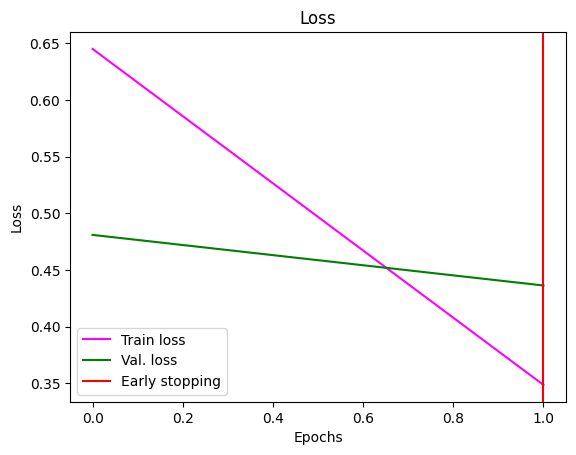

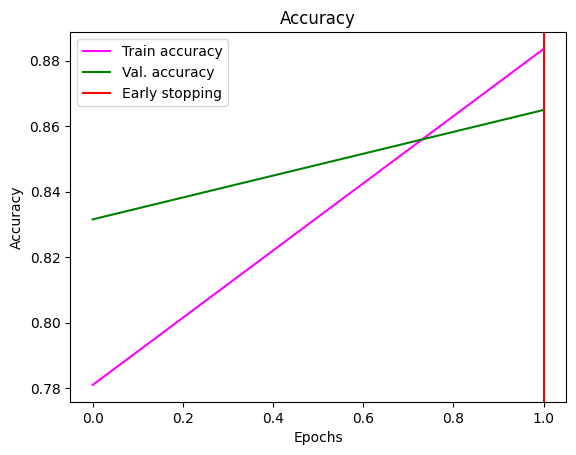

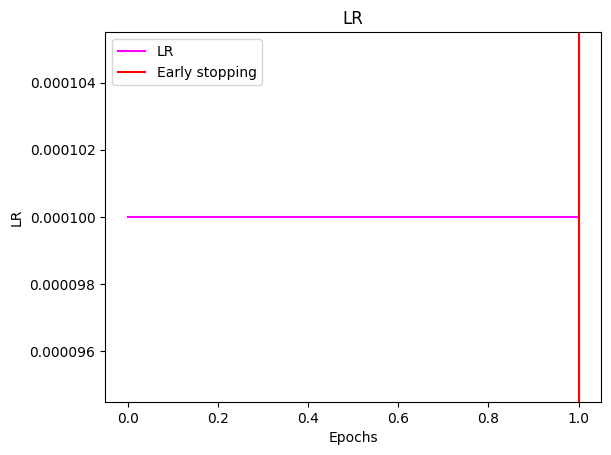

In [26]:
if TRAIN:
    # Lista com os indices das épocas. [0, 1, ... num_epochs - 1]
    epochs_list = []
    for i in range(len(train_loss_list)):
        epochs_list.append(i)

    # Plot - Loss 
    # -----------
    fig_obj = plt.figure()

    plt.title('Loss')
    plt.plot(epochs_list, train_loss_list, c='magenta', label='Train loss', fillstyle='none')
    plt.plot(epochs_list, val_loss_list, c='green', label='Val. loss', fillstyle='none')
    if args.es:
        plt.axvline(x=early_stopping.best_epoch, color='r', label='Early stopping')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    # Grava a figura em disco
    plt.savefig(os.path.join(EXP_PATH, 'chart_loss.png'))
    plt.savefig(os.path.join(EXP_PATH, 'chart_loss.pdf')) 

    # Plot - Accuracy
    # ---------------
    fig_obj = plt.figure()

    plt.title('Accuracy')
    plt.plot(epochs_list, train_acc_list, c='magenta', label='Train accuracy', fillstyle='none')
    plt.plot(epochs_list, val_acc_list, c='green', label='Val. accuracy', fillstyle='none')
    if args.es:
        plt.axvline(x=early_stopping.best_epoch, color='r', label='Early stopping')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Grava a figura em disco
    plt.savefig(os.path.join(EXP_PATH, 'chart_acc.png')) 
    plt.savefig(os.path.join(EXP_PATH, 'chart_acc.pdf')) 

    # Plot LR
    # ---------------
    fig_obj = plt.figure()

    plt.title('LR')
    plt.plot(epochs_list, lr_list, c='magenta', label='LR', fillstyle='none')
    if args.es:
        plt.axvline(x=early_stopping.best_epoch, color='r', label='Early stopping')
    plt.xlabel('Epochs')
    plt.ylabel('LR')
    plt.legend(loc='best')

    # Grava a figura em disco
    plt.savefig(os.path.join(EXP_PATH, 'chart_lr.png')) 
    plt.savefig(os.path.join(EXP_PATH, 'chart_lr.pdf')) 

### Saving trainning report

In [27]:
if TRAIN:
    # Arquivo CSV que irá armazenar todos os losses e acuracias.
    report_filename = os.path.join(EXP_PATH, 'training_report' + '.csv')

    # Cria o arquivo CSV
    report_file = open(report_filename, 'w')

    header = 'Epoch;Train Loss;Val. Loss;Train Acc.;Val. Acc.\n'
    report_file.write(header)

    # Putting values from each epoch inside of archive
    for i in range(0, len(train_loss_list)):
        text = str(i) + ';' + str(train_loss_list[i]) + ';' + str(val_loss_list[i]) + ';' + str(train_acc_list[i]) + ';' + str(val_acc_list[i]) + ';' + str(lr_list[i]) 
        if args.es and i == early_stopping.best_epoch:
            text += '; *\n'
        else:
            text += '\n'

        report_file.write(text)

    if args.es:
        report_file.write(f'Early stopping: ; {early_stopping.best_epoch}')

    # Closing
    report_file.close()

## Avaliando o modelo
---

In [28]:
def eval_model(mode='val'): 
    # Habilita o modelo para avaliação
    model.eval()

    # Listas com as classes reais (true), as classes preditas pelo modelo ('pred') e os caminhos para cada imagem (path). 
    true_list = []
    pred_list = []
    path_list = []

    prob_list = []

    # Inicia a contagem do tempo.
    time_start = time.time()

    # Selecionar o dataloader adequado.
    if mode == 'val':
        dataloader = dataloader_val2
    elif mode == 'test':
        dataloader = dataloader_test

    # Itera sobre o dataloader.
    # -------------------------
    for i, (img_batch, true_batch, path_batch) in enumerate(dataloader):

        # Envia os dados para a GPU
        img_batch = img_batch.to(DEVICE)
        true_batch = true_batch.to(DEVICE)

        # Para que o gradiente nao se atualize!
        torch.set_grad_enabled(False)

        # Saída do modelo 
        outputs = model(img_batch) 

        if num_classes == 2 and args.bce:
            # Calculate probabilities
            # https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/27
            outputs_prob = torch.sigmoid(outputs) 
            preds = (outputs_prob > 0.5).float().squeeze()

            prob_batch = np.asarray(outputs_prob.cpu())

            # We have the probability of class 0. Probability of class 0 is (1 - prob(c_1))
            prob_batch = np.c_[1. - prob_batch, prob_batch]

        else:
            preds = torch.argmax(outputs, dim=1)

            # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
            outputs_prob = nn.functional.softmax(outputs, dim=1)

            prob_batch = np.asarray(outputs_prob.cpu())

        # Lista de labels com a resposta (batch with 128 samples)
        true_batch = np.asarray(true_batch.cpu())
        # Lista de labels com a predicao (batch with 128 samples)
        pred_batch = np.asarray(preds.cpu(), dtype=int)
        # Lista com os caminhos das imagens (batch with 128 samples)
        path_batch = list(path_batch)

        # Consolidate das listas de predicao e resposta
        for i in range(0, len(pred_batch)):
            true_list.append(true_batch[i])
            pred_list.append(pred_batch[i])
            path_list.append(path_batch[i])

            prob_list.append(prob_batch[i])

    # Calculo do tempo total de teste
    time_total = time.time() - time_start

    return path_list, true_list, pred_list, prob_list, time_total

In [29]:
path_val_list, true_val_list, pred_val_list, prob_val_list, time_total_val = eval_model('val')
path_test_list, true_test_list, pred_test_list, prob_test_list, time_total_test = eval_model('test')

### Matriz de confusão e relatórios de classificação (Scikit-learn)

In [30]:
def gen_reports(mode='val'):
    if mode=='val':
        # Confusion matrix
        conf_mat = metrics.confusion_matrix(true_val_list, pred_val_list)
        # Classification report - Scikit-learn
        class_rep = metrics.classification_report(true_val_list, pred_val_list, 
                                                  target_names=class_names, digits=4)
        # Accuracy
        acc = metrics.accuracy_score(true_val_list, pred_val_list)

    elif mode=='test':
        # Confusion matrix
        conf_mat = metrics.confusion_matrix(true_test_list, pred_test_list)
        # Classification report - Scikit-learn
        class_rep = metrics.classification_report(true_test_list, pred_test_list, 
                                                  target_names=class_names, digits=4)
        # Accuracy
        acc = metrics.accuracy_score(true_test_list, pred_test_list)

    class_rep_path = os.path.join(EXP_PATH, f'classification_report_{mode}.txt')
    file_rep = open(class_rep_path, 'w')

    file_rep.write(f'\n\n{mode.upper()} SET:')
    file_rep.write('\n---------------')
    file_rep.write('\nConfusion matrix:\n')
    file_rep.write(str(conf_mat))
    file_rep.write('\n')
    file_rep.write('\nClassification report:\n')
    file_rep.write(class_rep)
    file_rep.write('\n')
    file_rep.write('\nAccuracy:;' + str(acc))

    file_rep.close()

    # Ploting the confusion matrix
    fig_obj = plt.figure()
    metrics.ConfusionMatrixDisplay(conf_mat).plot()
    # Save figure in disk
    plt.savefig(os.path.join(EXP_PATH, f'conf_mat_{mode}.png')) 
    plt.savefig(os.path.join(EXP_PATH, f'conf_mat_{mode}.pdf')) 

    print(conf_mat)
    print(class_rep)
    print(f'{mode.upper()} Acc.: {acc:.4f}')

    return acc, class_rep_path

[[ 137    6   37    2    4   28    2    1    8]
 [   0  197   13    0    1    0    0    2    0]
 [   3   27 1699    3   21   52    2   11    3]
 [   0    0   12  164    0   30    0    0    0]
 [   0    0    5    0  184   16    0    0    0]
 [   0    0    7    1    1  203    0    0    0]
 [   1    2   36    2    1    1  153    5    1]
 [   0    5   48    0    1    0    0  161    0]
 [   9    8   32    0    3   15    2    3  131]]
                precision    recall  f1-score   support

       Lantana     0.9133    0.6089    0.7307       225
  Chinee apple     0.8041    0.9249    0.8603       213
    Parthenium     0.8994    0.9330    0.9159      1821
      Negative     0.9535    0.7961    0.8677       206
    Snake weed     0.8519    0.8976    0.8741       205
     Siam weed     0.5884    0.9575    0.7289       212
   Parkinsonia     0.9623    0.7574    0.8476       202
   Rubber vine     0.8798    0.7488    0.8090       215
Prickly acacia     0.9161    0.6453    0.7572       203

     

<Figure size 640x480 with 0 Axes>

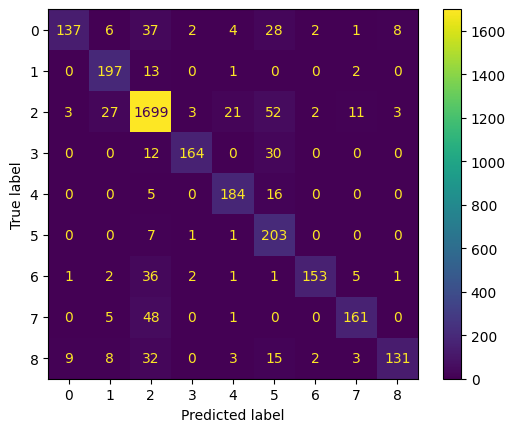

<Figure size 640x480 with 0 Axes>

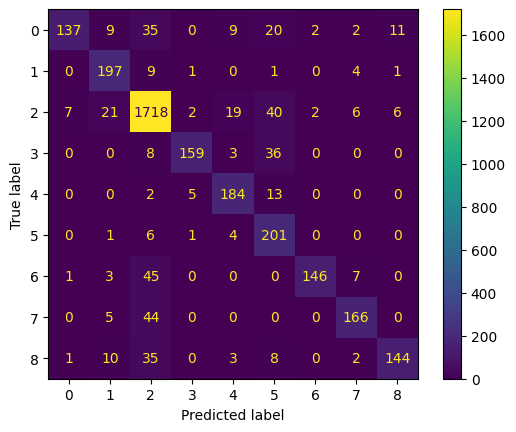

In [31]:
acc_val, _ = gen_reports('val')
acc_test, class_rep_test_path = gen_reports('test')

### Classification report

In [32]:
def class_rep(mode='val'):
    """
    Usa o método __get_item__ da classe ... extendida da classe Dataset
    """

    if mode=='val':
        true_list = true_val_list
        pred_list = pred_val_list
        prob_list = prob_val_list
        path_list = path_val_list

    elif mode=='test':
        true_list = true_test_list
        pred_list = pred_test_list
        prob_list = prob_test_list
        path_list = path_test_list

    file_details_path = os.path.join(EXP_PATH, f'classification_details_{mode}.csv')
    file_details = open(file_details_path, 'w')

    file_details.write(f'{mode.upper()} SET')
    file_details.write('\n#;File path;Target;Prediction')

    for class_name in class_names:
        file_details.write(';' + str(class_name))

    for i, (target, pred, probs) in enumerate(zip(true_list, pred_list, prob_list)):
        image_name = str(path_list[i])
        file_details.write('\n' + str(i) + ';' + image_name + ';' + str(target) + ';' + str(pred))

        for prob in probs:
            file_details.write(';' + str(prob))

    file_details.close()

In [33]:
class_rep('val')
class_rep('test')

In [34]:
# Calcula do tempo total do experimento.
time_exp_total = time.time() - time_exp_start

### General report (Including hyperparameter optimization)

In [35]:
if args.optim != 'none':
    print('\n>> Relatório da otimização de hiperparametros...')
    # O nome de um arquivo CSV. Irá armazenar todos os losses e acuracias.
    # Se otimização de hiperparametros, separar por arquitetura
    hp_filename = os.path.join(EXP_PATH_MAIN, '(' + args.ds + ')-' + args.arch + '-' + args.optim + '.csv')
else:
    print('\n>> Relatório do conjunto de experimentos...')
    # O nome de um arquivo CSV. Irá armazenar todos os losses e acuracias.
    hp_filename = os.path.join(EXP_PATH_MAIN, '(' + args.ds + ')-' + args.optim + '.csv')


if args.ec == 0:
    # Cria o arquivo CSV
    hp_file = open(hp_filename, 'w')

    # Cria cabeçalho
    header = '#;DS;ARCH;HP;FT;DA_TRAIN;DA_VAL;DA_TEST;BS;LR;MM;SS;EP;ES;ACC_VAL;ACC_TEST;ACC_TRAIN(*);ACC_VAL(*);TIME_TRAIN;TIME_VAL;TIME_TEST;TIME_EXP\n'
    hp_file.write(header)

else:
    # Cria o arquivo CSV
    hp_file = open(hp_filename, 'a')


# Momentum. Only if optmizer is SGD
mm_str = f'{args.mm}' if args.optimizer == 'SGD' else ''
# Step size. Only if scheduler is steplr
ss_str = f'{args.ss}' if args.scheduler == 'steplr' else ''
# Early stopping
es_ = early_stopping.best_epoch if args.es else args.ep - 1

info = f'{args.ec};{args.ds};{args.arch};{args.optim};{args.ft};{args.datrain};{args.daval};{args.datest};' + \
       f'{args.bs};{args.lr};' + \
       f'{mm_str};{ss_str};' + \
       f'{args.ep};{es_};' + \
       f'{acc_val};{acc_test};{train_acc_list[early_stopping.best_epoch]};{val_acc_list[early_stopping.best_epoch]};' + \
       f'{str(datetime.timedelta(seconds=time_total_train))};{str(datetime.timedelta(seconds=time_total_val))};' + \
       f'{str(datetime.timedelta(seconds=time_total_test))};{str(datetime.timedelta(seconds=time_exp_total))}\n'

hp_file.write(info)

hp_file.close()


>> Relatório do conjunto de experimentos...


## Done!
---

In [36]:
# Se o arquivo "done.txt" estiver na pasta, o experimento foi finalizado com sucesso!
done_file = open(os.path.join(EXP_PATH, 'done.txt'), 'w')
done_file.close()

print('\nDone!\n\n')


Done!




## References 
---

* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/finetuning_torchvision_models_tutorial.ipynb 
* https://github.com/Spandan-Madan/Pytorch_fine_tuning_Tutorial
* https://huggingface.co/docs/transformers/training
* https://pytorch.org/vision/stable/models.html
* https://paperswithcode.com/lib/timm